# Sparkify Project Workspace

In this notebook, a model was built to predict the chrn for Sparkify, an imaginary music streaming application. The log files is avaiable and has been cleaned and feature engineering in order to be able to predict churn. The Spark was used to process the data and build the model. This project is done on IBM Watson cloud workspace. 

We performed EDA to establish features, and train several machine learning classification models. We used F1 score to measure of model performance. The model we built and selected has a F1 score of 0.7. 

We first load the necessary libraries.

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190803060457-0000
KERNEL_ID = b0ca2c47-76c5-49f9-9f54-b79e7bf90598


In [66]:
# import libraries
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# import pyspark related libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import datetime as dt
import pyarrow as pa

In [65]:
!pip install pyarrow

    100% |################################| 58.1MB 307kB/s eta 0:00:01
    100% |################################| 20.4MB 856kB/s eta 0:00:01 0% |                                | 92kB 36.8MB/s eta 0:00:01
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.


In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Load and Clean Dataset
In this workspace, the mini-dataset file is `medium-sparkify-event-data.json`. Load and clean the dataset, checking for any invalid or missing data. 

In [4]:
# Read in full sparkify dataset

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'sparkify-donotdelete-pr-ma7s7cezdcowaq'))
df.persist()
#df.take(2)

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.show(3)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|              song|status|           ts|           userAgent|userId|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------------------+------+-------------+--------------------+------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|     Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|   PUT|NextSong|1538069638000|    

In [6]:
# Print schema 
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Schema information

- artist: Artist name (ex. 'Martin Orford')
- auth: User authentication status (ex. 'Logged In')
- firstName: User first name (ex. 'Joseph')
- gender: Gender (ex. F or M)
- itemInSession: Item count in a session (ex. 20)
- lastName: User last name (ex. 'Morales')
- length: Length of song (ex. 597.55057)
- level: User plan (ex. 'free')
- location: User's location (ex. 'Corpus Christi, TX')
- method: HTTP method (ex. PUT)
- page: Page name (ex. 'NextSong')
- registration: Registration timestamp (unix timestamp) (ex. 1532063507000)
- sessionId: Session ID (ex. 292)
- song: Song (ex. 'Grand Designs')
- status: HTTP status (ex. 200)
- ts: Event timestamp(unix timestamp) (ex. 11538352011000)
- userAgent: User's browswer agent (ex. '"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"')
- userId: User ID (ex. 293)

#### Deal with missing data

In [7]:
# check missing data
print("Percentage of missing data\n")

for col in df.columns:

    missing_count = df.filter((df[col].isNull()) | (df[col] == "")).count()*100 
    
    if missing_count > 0:
        print("{}: {:.2f} %".format(col, missing_count/df.count()))

Percentage of missing data

artist: 20.38 %
firstName: 2.89 %
gender: 2.89 %
lastName: 2.89 %
length: 20.38 %
location: 2.89 %
registration: 2.89 %
song: 20.38 %
userAgent: 2.89 %
userId: 2.89 %


In [8]:
# # clean missing value in userId and sessionId
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
df_clean = df_clean.filter((df["userId"].isNull()) | (df["userId"] != "")) 

print('After clean:\n')
print('Missing data in userId:',df_clean.filter(df_clean['userId'] == '').count())
print('Missing data in sessionId:',df_clean.filter(df_clean['sessionId'] == '').count())

After clean:

Missing data in userId: 0
Missing data in sessionId: 0


#### check data type

In [9]:
num_cols = []
cat_cols = []

for s in df_clean.schema:
    data_type = str(s.dataType)
    if data_type == "StringType":
        cat_cols.append(s.name)
    
    if data_type == "LongType" or data_type == "DoubleType":
        num_cols.append(s.name)

In [10]:
print('numerical columns:',num_cols)
print('catagorical columns:',cat_cols)

numerical columns: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']
catagorical columns: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']


### Exploratory Data Analysis
EDA is performed by loading a small subset of the data and doing basic manipulations within Spark. 



#### Preliminary analysis

In [11]:
df_clean.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
df_clean.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   296|
|100010|
|200002|
|   124|
|    51|
|200037|
|    54|
|   234|
|100014|
|   154|
+------+
only showing top 10 rows



#### Convert timestamp to clean time format

In [13]:
# convert timestamp to clean time format
# add a time column to df
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_clean = df_clean.withColumn('event_time', convert_ts('ts'))
df_clean = df_clean.withColumn('registration_time', convert_ts('registration'))

In [14]:
df_clean.select(["userId", "page", "event_time", "level", "song", "sessionId"]).where(df.userId == "18").sort("event_time").show(10)

+------+--------+-------------------+-----+--------------------+---------+
|userId|    page|         event_time|level|                song|sessionId|
+------+--------+-------------------+-----+--------------------+---------+
|    18|    Home|2018-10-01 04:53:06| paid|                null|      476|
|    18|NextSong|2018-10-01 04:54:36| paid|I'm The One Who U...|      476|
|    18|NextSong|2018-10-01 04:59:26| paid|Sound Of Madness ...|      476|
|    18|    Home|2018-10-01 05:01:09| paid|                null|      476|
|    18|NextSong|2018-10-01 05:03:19| paid|          Fuck Kitty|      476|
|    18|NextSong|2018-10-01 05:05:33| paid|Ghost Of The Navi...|      476|
|    18|NextSong|2018-10-01 05:12:22| paid|         On The Rise|      476|
|    18|NextSong|2018-10-01 05:16:14| paid|Was soll ich ihr ...|      476|
|    18|NextSong|2018-10-01 05:18:58| paid|    Ain't Misbehavin|      476|
|    18|NextSong|2018-10-01 05:21:00| paid|Face Down (Album ...|      476|
+------+--------+--------

#### Define Churn

Create a column `Churn` to use as the label for the model. We used the `Cancellation Confirmation` events to define the churn, which happen for both paid and free users. We also looked into the `Downgrade` events as defined by `Submit Downgrade`.

In [15]:
# create churn label
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_clean = df_clean.withColumn('churn_event', churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_clean = df_clean.withColumn('churn', max('churn_event').over(windowval))

# create downgrade label
downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df_clean = df_clean.withColumn("downgrade_event", downgrade_event("page"))

# label user who've ever downgraded
windowval = Window.partitionBy('userId')
df_clean = df_clean.withColumn('downgrade', max('downgrade_event').over(windowval))

In [16]:
df_clean.select(["userId", "gender", "level", "churn",'downgrade']).dropDuplicates().show(10)

+------+------+-----+-----+---------+
|userId|gender|level|churn|downgrade|
+------+------+-----+-----+---------+
|100010|     F| free|    1|        0|
|200002|     M| free|    1|        0|
|200002|     M| paid|    1|        0|
|   296|     F| free|    1|        0|
|   296|     F| paid|    1|        0|
|   125|     M| free|    0|        0|
|   124|     F| paid|    1|        0|
|    51|     M| paid|    1|        0|
|     7|     M| free|    0|        0|
|200037|     M| free|    1|        0|
+------+------+-----+-----+---------+
only showing top 10 rows



#### Explore Data
Next, we perform exploratory data analysis to observe the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**1) Gender**

Male churn rate:21.60 %
Female churn rate:22.73 %
Gender does not have a significant effect on churn


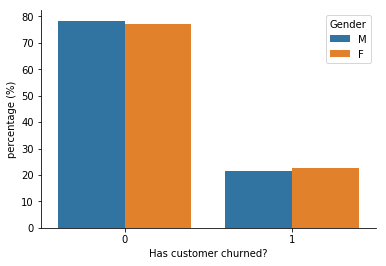

In [18]:
churn_gender = df_clean.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

F_sum = churn_gender[churn_gender['gender']=='F']['count'].sum()
M_sum = churn_gender[churn_gender['gender']=='M']['count'].sum()

p_M=pd.DataFrame({'percentage':churn_gender[churn_gender['gender']=='M']['count']/M_sum*100})
p_F=pd.DataFrame({'percentage':churn_gender[churn_gender['gender']=='F']['count']/F_sum*100})
       
pp = pd.concat([p_M, p_F], axis=0)
churn_gender = pd.concat([churn_gender, pp], axis=1)

ax = sns.barplot(x='churn', y='percentage', hue='gender', data=churn_gender)
plt.xlabel('Has customer churned?')
plt.ylabel('percentage (%)')
plt.legend(title='Gender', loc='best')
#plt.title('')
sns.despine(ax=ax);

print('Male churn rate:{:.2f} %' .format(churn_gender[(churn_gender.churn==1)& (churn_gender.gender=='M')]['percentage'].tolist()[0]))
print('Female churn rate:{:.2f} %'.format(churn_gender[(churn_gender.churn==1)& (churn_gender.gender=='F')]['percentage'].tolist()[0]))
print('Gender does not have a significant effect on churn')

**2) Level (paid vs free)**

free churn rate: 25.00 %
paid churn rate: 18.22 %
Churn usually happens when a customer is using a free plan


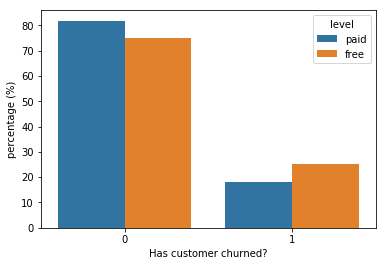

In [19]:
pd_level = df_clean.select(["userId", "level", "churn"]).groupby('level', 'churn').count().toPandas()

a = pd_level[pd_level['level']=='paid']['count'].tolist()[0]/pd_level[pd_level['level']=='paid']['count'].sum()
b = pd_level[pd_level['level']=='free']['count'].tolist()[0]/pd_level[pd_level['level']=='free']['count'].sum()

pd_level_p = pd.DataFrame({'percentage':[a*100, b*100, 100*(1-a), 100*(1-b)]})

pd_level = pd.concat([pd_level, pd_level_p], axis=1, sort=False)

ax = sns.barplot(data=pd_level, x='churn', y='percentage', hue='level')#, color=sns.color_palette()[0])
plt.xlabel('Has customer churned?')
plt.ylabel('percentage (%)')
plt.title('')

print('free churn rate: {:.2f} %'.format(pd_level[(pd_level.churn==1)& (pd_level.level=='free')]['percentage'].tolist()[0]))
print('paid churn rate: {:.2f} %'.format(pd_level[(pd_level.churn==1)& (pd_level.level=='paid')]['percentage'].tolist()[0]))
print('Churn usually happens when a customer is using a free plan')

**3) Page used**

In [20]:
churn_count = df_clean.filter(df_clean['churn']==1).count()
no_churn_count = df_clean.filter(df_clean['churn']==0).count()

# drop next song page because it is not very predictive
# of much other than that users are using the primary feature
# of a music streaming app, namely, listening to music

df_temp1 = df_clean.filter(df_clean['churn']==1).filter(df_clean['page']!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("churn", df_temp1["count"]/churn_count*100).sort("page")

df_temp2 = df_clean.filter(df_clean['churn']==0).filter(df_clean['page']!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("non_churn", df_temp2["count"]/no_churn_count*100).sort("page")

<Figure size 432x288 with 0 Axes>

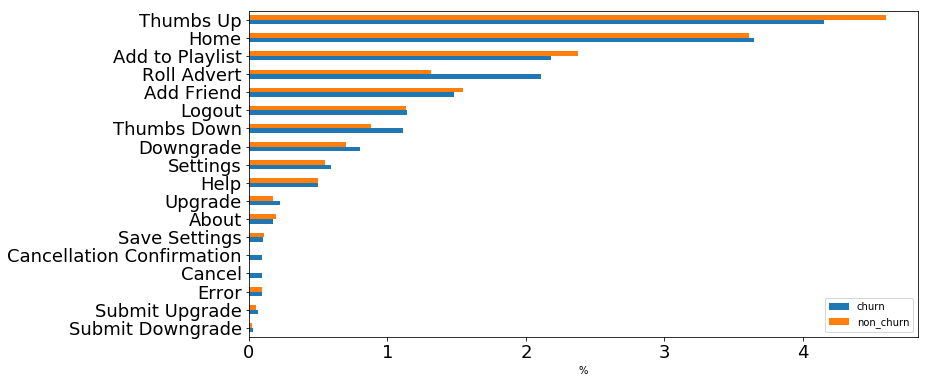

In [22]:
df_pageuse = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pageuse = df_pageuse.sort_values(by=['churn'], ascending=True)
plt.figure()
df_pageuse.plot.barh("page", figsize=(12,6), fontsize=18)
plt.xlabel('%')
plt.ylabel('')
plt.show()

**4) # of session**

Churn usually happens when a customer subscribed less sessions


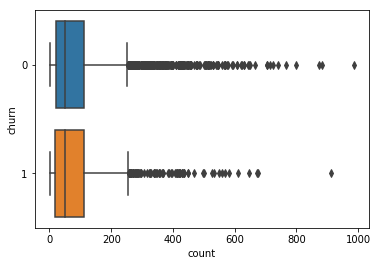

In [23]:
# churn # of session
df_pd = df_clean.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)
print('Churn usually happens when a customer subscribed less sessions')

**5) churn hourly**

In [24]:
# churn hourly
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_clean = df_clean.withColumn("hour", get_hour(df_clean.ts))

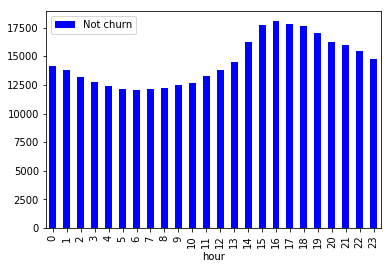

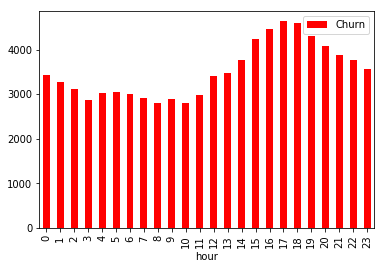

In [26]:
df_pd = df_clean.filter(df_clean.page == "NextSong").groupby("churn", 'hour').count().orderBy(df_clean['hour'].cast("float")).toPandas()
df_pd['hour'] = pd.to_numeric(df_pd['hour'])
df_pd[df_pd.churn==0].plot.bar(x='hour', y='count', color='Blue', label='Not churn')
df_pd[df_pd.churn==1].plot.bar(x='hour', y='count', color='Red', label='Churn')

**6) total length**

Churn usually happens when a customer subscribed less length of song


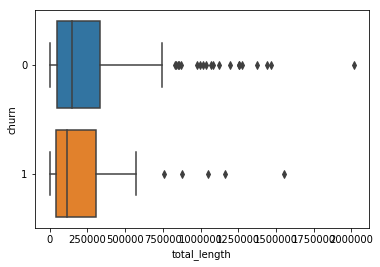

In [27]:
# length 
pd_length = df_clean.select('userID', 'churn', 'length')\
            .groupby("userId", 'churn') \
            .agg({"length": "sum"}) \
            .withColumnRenamed("sum(length)", "total_length").toPandas()
#pd_length.head()

sns.boxplot(y='churn', x='total_length', orient="h", data=pd_length)
print('Churn usually happens when a customer subscribed less length of song')
#pd_length.head()

**7) day since registration (lifetime)**

In [29]:
lt_pd = df_clean \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df_clean.ts-df_clean.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime').toPandas() \
    #.select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    #.toPandas()
#lt_pd.show(2)

Churned customers use the service for a shorter period of time


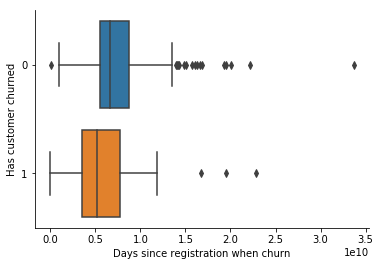

In [30]:
ax = sns.boxplot(data=lt_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
sns.despine(ax=ax);
print('Churned customers use the service for a shorter period of time')

**8) total songs**

In [31]:
df_song = df_clean \
    .select('userID','song','churn') \
    .groupBy('userID', 'churn') \
    .count() \
    .withColumnRenamed('count', 'total_songs') \
    .toPandas()

Churned customer listens less songs


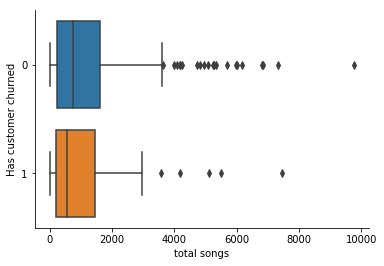

In [33]:
ax = sns.boxplot(data=df_song, y='churn', x='total_songs', orient='h')
plt.xlabel('total songs')
plt.ylabel('Has customer churned')
sns.despine(ax=ax);
print('Churned customer listens less songs')

## Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
# Time since registration
f1 = df_clean \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df_clean.ts-df_clean.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') #\
    #.select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
print(f1.count())
f1.toPandas().isnull().sum()

448


userId      0
lifetime    0
dtype: int64

In [35]:
# Total songs listened
f2 = df_clean \
    .select('userID','song') \
    .groupby('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs')
print(f2.count())
f2.toPandas().isnull().sum()

448


userID         0
total_songs    0
dtype: int64

In [36]:
#data_w_churn.select('sessionId').toPandas().sessionId.value_counts()
f3 = df_clean \
    .select('userId', 'sessionId')\
    .groupby('userId')\
    .count()\
    .withColumnRenamed('count', 'total_sesson')
print(f3.count())
f3.toPandas().isnull().sum()

448


userId          0
total_sesson    0
dtype: int64

In [37]:
# Number of Thumbs-Up/Down
f4 = df_clean \
    .select('userID','page') \
    .where(df_clean.page == 'Thumbs Up') \
    .groupby('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_up') 
print(f4.count())
f4.toPandas().isnull().sum()

439


userID          0
num_thumb_up    0
dtype: int64

In [38]:
f5 = df_clean \
    .select('userID','page') \
    .where(df_clean.page == 'Thumbs Down') \
    .groupby('userID') \
    .count() \
    .withColumnRenamed('count', 'num_thumb_down')
print(f5.count())
f5.toPandas().isnull().sum()

389


userID            0
num_thumb_down    0
dtype: int64

In [39]:
flag_gender = udf(lambda x: 1 if x == "M" else 0, IntegerType())

f6 = df_clean\
    .select(['userId', 'gender'])\
    .dropDuplicates() \
    .withColumn("gender", flag_gender("gender"))
    
   # .select('userId', col('gender').cast('int'))

print(f6.count())
f6.toPandas().isnull().sum()

448


userId    0
gender    0
dtype: int64

In [40]:
# Number of songs added to playlist
f7 = df_clean \
    .select('userID','page') \
    .where(df_clean['page'] == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_to_playlist')
print(f7.count())
f7.toPandas().isnull().sum()

428


userID             0
add_to_playlist    0
dtype: int64

In [41]:
# Number of friends added
f8 = df_clean \
    .select('userID','page') \
    .where(df_clean['page'] == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'add_friend') 
print(f8.count())
f8.toPandas().isnull().sum()

409


userID        0
add_friend    0
dtype: int64

In [42]:
# Total length of listening
f9 = df_clean \
    .select('userID','length') \
    .groupby('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
print(f9.count())
f9.toPandas().isnull().sum()

448


userID         0
listen_time    0
dtype: int64

In [43]:
# Number of songs listened per session
f10 = df_clean.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
print(f10.count())
f10.toPandas().isnull().sum()

448


userId              0
avg_songs_played    0
dtype: int64

**churn label**

In [44]:
# Churn label
label = df_clean \
    .groupby('userId')\
    .max('churn')\
    .withColumnRenamed("max(churn)", "label")\
    .dropDuplicates()
print(label.count())
label.toPandas().isnull().sum()

#df_original = df_churn.groupby('userId').max("churn").withColumnRenamed("max(churn)", "target")

448


userId    0
label     0
dtype: int64

In [75]:
# Construct 
df_spark = f1.join(f2,'userID','outer') \
    .join(f3,'userID','outer') \
    .join(f4,'userID','outer') \
    .join(f5,'userID','outer') \
    .join(f6,'userID','outer') \
    .join(f7,'userID','outer') \
    .join(f8,'userID','outer') \
    .join(f9,'userID','outer') \
    .join(f10,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

df_spark.show(5)

+----------+-----------+------------+------------+--------------+------+---------------+----------+------------------+------------------+-----+
|  lifetime|total_songs|total_sesson|num_thumb_up|num_thumb_down|gender|add_to_playlist|add_friend|       listen_time|  avg_songs_played|label|
+----------+-----------+------------+------------+--------------+------+---------------+----------+------------------+------------------+-----+
|1237978000|        137|         137|           4|             3|     0|              1|         3|25870.950739999997|              48.0|    1|
|4607120000|        395|         395|          15|             5|     1|              6|         2| 78695.82683999998|              62.0|    1|
|2301546000|        152|         152|           8|             0|     0|              3|         2|28314.150059999996|              22.4|    1|
|9108471000|         84|          84|           3|             1|     1|              2|         3|15813.771070000003|20.666666666666668

### Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I use F1 score as the metric to optimize.

In [76]:
feature_columns = df_spark.columns [:-1]

In [77]:
train, test = df_spark.randomSplit([0.8, 0.2], seed=43)

In [78]:
def build_model(classifier, param):
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd = True)
    pipeline = Pipeline(stages=[assembler, scaler, classifier])

    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param,
        evaluator=MulticlassClassificationEvaluator(labelCol='label', metricName='f1'),
        numFolds=5,
    )
    return model

**Model 1: Logistic regression**

In [79]:
# logistic regression
lr = LogisticRegression(featuresCol="scaled_features", labelCol="label")
# hyperparameter tuning
param_lr = ParamGridBuilder().addGrid(lr.regParam, [0.0,0.1,0.01]).build()
model_lr = build_model(lr, param_lr)

In [80]:
%%time
fit_model_lr = model_lr.fit(train)

CPU times: user 59.7 s, sys: 27.8 s, total: 1min 27s
Wall time: 28min 10s


In [81]:
pred_lr = fit_model_lr.transform(test)

In [82]:
pred_lr.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [83]:
evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "accuracy"})
f1_score_lr = evaluator_lr.evaluate(pred_lr, {evaluator_lr.metricName: "f1"})

print('Logistic Regression Metrics:')
print("Accuracy: {}".format(accuracy_lr))
print("F1 score: {}".format(f1_score_lr))

Logistic Regression Metrics:
Accuracy: 0.8210526315789474
F1 score: 0.7800091945840935


**Model 2: Randon forest**

In [86]:
# randon forest
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label")
# hyperparameter tuning
param_rf = ParamGridBuilder()\
            .addGrid(rf.numTrees, [5,10,20])\
            .addGrid(rf.maxDepth, [1,5]).build()

model_rf = build_model(rf, param_rf)

In [87]:
%%time
fit_model_rf = model_rf.fit(train)

CPU times: user 41.7 s, sys: 18.7 s, total: 1min
Wall time: 20min 57s


In [88]:
pred_rf = fit_model_rf.transform(test)

In [89]:
pred_rf.select("prediction").dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [90]:
evaluator_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "accuracy"})
f1_score_rf = evaluator_rf.evaluate(pred_rf, {evaluator_rf.metricName: "f1"})

print('Random Forest Metrics:')
print("Accuracy: {}".format(accuracy_rf))
print("F1 score: {}".format(f1_score_rf))

Random Forest Metrics:
Accuracy: 0.8315789473684211
F1 score: 0.7983139667350192


**Model 3: Gradient-Boosted tree classifier**

In [91]:
# Gradient-boosted tree classifier
gbt =GBTClassifier(featuresCol="scaled_features", labelCol="label")
# hyperparameter tuning
param_gbt = ParamGridBuilder()\
  # .addGrid(gbt.maxIter, [5,10,20])\
    .addGrid(gbt.maxDepth, [1,5])\
    .build()
model_gbt = build_model(gbt, param_gbt)

IndentationError: unexpected indent (<ipython-input-91-ec11c3a5c58b>, line 5)

In [ ]:
%%time
fit_model_gbt = model_gbt.fit(train)

In [ ]:
pred_gbt = fit_model_gbt.transform(test)

In [ ]:
pred_gbt.select("prediction").dropDuplicates().collect()

In [ ]:
evaluator_gbt = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_rf.metricName: "accuracy"})
f1_score_gbt = evaluator_gbt.evaluate(pred_gbt, {evaluator_rf.metricName: "f1"})

print('Gradient-boosted tree Metrics:')
print("Accuracy: {}".format(accuracy_gbt))
print("F1 score: {}".format(f1_score_gbt))

**Feature importance**

In [ ]:
fit_model_rf.bestModel.stages[2]

In [ ]:
# feature importance

rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df['feature'] = feature_columns
rf_feature_importance_df['importance'] = fit_model_rf.bestModel.stages[2].featureImportances.values.tolist()
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

In [ ]:
plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=rf_feature_importance_df, color="b")
plt.title('Feature Importance')
plt.ylabel('');

### Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.